In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('restaurant_reviews.tsv',sep='\t')
print(f'The no. of data points is {len(data)}')
print(data['Liked'].value_counts())

The no. of data points is 1000
1    500
0    500
Name: Liked, dtype: int64


In [3]:
import re

def de_html(target):
    filtered = re.sub(r'<.*>',' ',target)
    return filtered

def de_special_chars(target):
    cleaned = re.sub(r'[?|!|\'|"|#|$|@|&|%]',' ',target)
    cleaned = re.sub(r'[.|,|)|(|\\|/]',' ',cleaned)
    return cleaned

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [5]:
negative_words = []
positive_words = []
cleaned_data = []
review_count = 0

for review in data['Review']:
    cleaned_review = []
    review = de_html(review)
    review = de_special_chars(review)
    for word in review.split():
        if word.lower() not in stop_words:
            if word.isalpha() and len(word) > 2:
                if data.iloc[review_count,-1]:
                    positive_words.append(word.lower())
                else:
                    negative_words.append(word.lower())
                stemmed_word = stemmer.stem(word.lower())
                cleaned_review.append(stemmed_word)
    cleaned_review = ' '.join(cleaned_review)
    cleaned_data.append(cleaned_review)
    review_count += 1


In [9]:
from nltk import FreqDist
frequency = FreqDist(positive_words)
print(frequency.most_common(10))

[('good', 73), ('great', 70), ('food', 60), ('place', 57), ('service', 45), ('friendly', 24), ('delicious', 23), ('back', 23), ('amazing', 22), ('nice', 22)]


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
word_model = CountVectorizer(binary=True)
bag_of_words = word_model.fit_transform(cleaned_data)
target_labels = data.iloc[:,-1].values

In [12]:
from sklearn.model_selection import train_test_split
ind_train,ind_test,dep_train,dep_test = train_test_split(bag_of_words,target_labels,test_size=0.2,random_state=0)

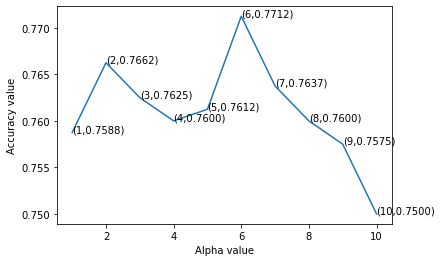

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt

alpha_values = list(range(1,11))
acc_values = []

for alph in alpha_values:
    model = BernoulliNB(alpha=alph)
    accuracy_result = cross_val_score(model,ind_train,dep_train,cv=10,scoring='accuracy')
    acc_values.append(accuracy_result.mean())

plt.plot(alpha_values,acc_values)

for alph,acc in list(zip(alpha_values,acc_values)):
    plt.annotate(f'({alph},{acc:.4f})',xy=(alph,acc))

plt.xlabel('Alpha value')
plt.ylabel('Accuracy value')
plt.show()

In [17]:
model = BernoulliNB(alpha=6)
model.fit(ind_train,dep_train)
results = model.predict(ind_test)

In [31]:

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
matrix = confusion_matrix(dep_test,results)
accuracy_score = accuracy_score(dep_test,results)

probs_result = model.predict_proba(ind_test)
max_label_probs = probs_result[:,1]
    
auc_score = roc_auc_score(dep_test,max_label_probs)

print(f'The confusion matrix looks like:\n {matrix}')
print(f'The accuracy score is {accuracy_score}')
print(f'The AUC score is {auc_score}')

The confusion matrix looks like:
 [[81 16]
 [29 74]]
The accuracy score is 0.775
The AUC score is 0.8410569512561304


In [33]:
probs_result[:10,1]

array([0.42145648, 0.26206118, 0.29664678, 0.3988177 , 0.30395464,
       0.28305004, 0.98290583, 0.1139401 , 0.1227548 , 0.70978552])